Results for sub-011_ses-01_recording-01_time-0-72h_sr-1hz.csv:
timePeriod
Dark     18.400085
Light    17.445589
dtype: float64

Results for sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv:
timePeriod
Dark      8.283372
Light    13.440605
dtype: float64

Results for sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz.csv:
timePeriod
Dark     17.550081
Light    17.325096
dtype: float64

t-statistic: 0.6880023176805441
p-value: 0.562530923346898
Fail to reject null hypothesis: Light and Dark transitions per hour are not significantly different.


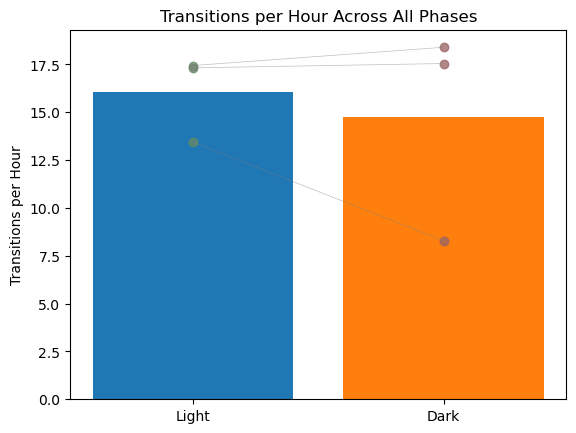

In [4]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Calculate transitions per hour for each phase
    transitions_per_hour = df.groupby('timePeriod')['sleepStageChange'].sum() / df.groupby('timePeriod')['Timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600)
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'transitions_per_hour': transitions_per_hour,
    }

# Print results
for filename, result in results.items():
    print(f"Results for {filename}:")
    print(result['transitions_per_hour'])
    print()

# Create lists to store light and dark transitions per hour
light_transitions_per_hour = []
dark_transitions_per_hour = []

for filename, result in results.items():
    light_transition_per_hour = result['transitions_per_hour']['Light']
    dark_transition_per_hour = result['transitions_per_hour']['Dark']
    light_transitions_per_hour.append(light_transition_per_hour)
    dark_transitions_per_hour.append(dark_transition_per_hour)

# Run paired samples t-test
t_stat, p_val = stats.ttest_rel(light_transitions_per_hour, dark_transitions_per_hour)

print("t-statistic:", t_stat)
print("p-value:", p_val)

# Interpret p-value
alpha = 0.05
if p_val < alpha:
    print("Reject null hypothesis: Light and Dark transitions per hour are significantly different.")
else:
    print("Fail to reject null hypothesis: Light and Dark transitions per hour are not significantly different.")

# Create a figure and axis
fig, ax = plt.subplots()

# Define bar positions and width
bar_width = 0.8
bar_positions = np.arange(2)

# Calculate mean and standard error for bars
light_mean = np.mean(light_transitions_per_hour)
light_sem = stats.sem(light_transitions_per_hour)
dark_mean = np.mean(dark_transitions_per_hour)
dark_sem = stats.sem(dark_transitions_per_hour)

ax.bar(bar_positions[0], light_mean, bar_width, label='Light', capsize=5)
ax.bar(bar_positions[1], dark_mean, bar_width, label='Dark', capsize=5)

# Add lines connecting individual subject means
for i in range(len(light_transitions_per_hour)):
    ax.plot(bar_positions, [light_transitions_per_hour[i], dark_transitions_per_hour[i]], 'o-', linewidth=0.5, color='gray', alpha=0.5)

# Add scatter plot for individual means
ax.scatter(np.repeat(bar_positions[0], len(light_transitions_per_hour)), light_transitions_per_hour, alpha=0.5)
ax.scatter(np.repeat(bar_positions[1], len(dark_transitions_per_hour)), dark_transitions_per_hour, alpha=0.5)

# Set x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(['Light', 'Dark'])

# Add legend and labels
ax.set_ylabel('Transitions per Hour')
ax.set_title('Transitions per Hour Across All Phases')

# Show plot
plt.show()

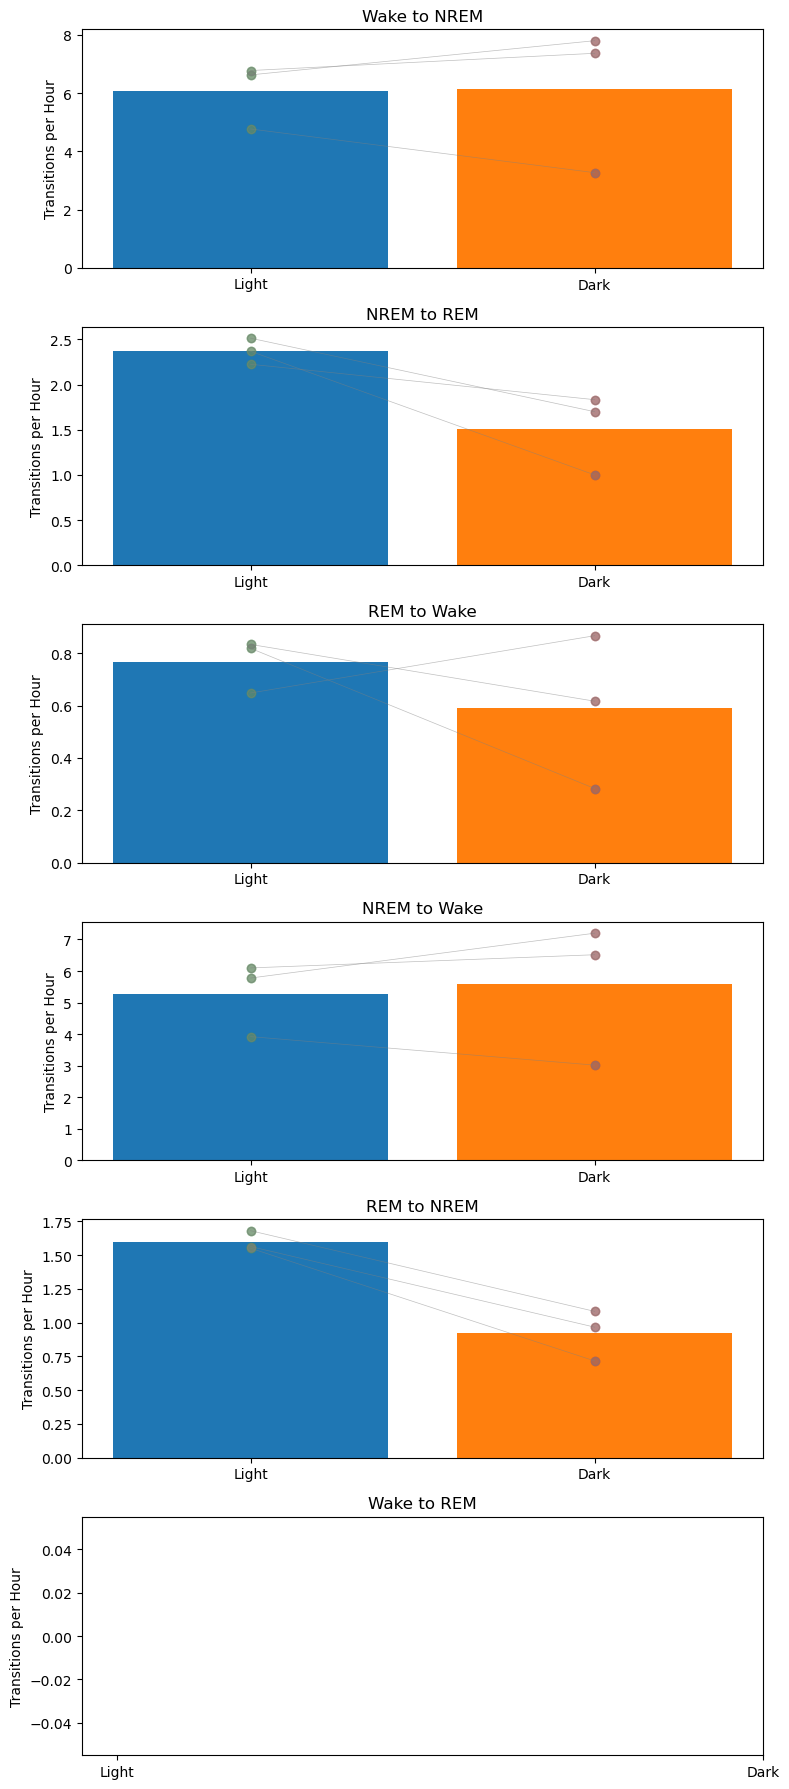

In [17]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# List of CSV file paths
csv_files = glob.glob('/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/*.csv')

# Dictionary to store results
results = {}

for file in csv_files:
    # Load the CSV file
    df = pd.read_csv(file)
    
    # Convert Timestamp column to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Round the numbers in the sleepStage column to the nearest integer
    df['sleepStage'] = df['sleepStage'].round().astype(int)
    
    # Create a new column to track changes in sleep stage
    df['sleepStageChange'] = df['sleepStage'] != df['sleepStage'].shift()
    
    # Determine the time period (light or dark) for each row
    def get_time_period(row):
        hour = row['Timestamp'].hour
        if 9 <= hour < 21:
            return 'Light'
        else:
            return 'Dark'
    
    df['timePeriod'] = df.apply(get_time_period, axis=1)
    
    # Map sleep stages to their corresponding names (optional)
    sleep_stage_map = {1: 'Wake', 2: 'NREM', 3: 'REM'}
    df['sleepStage'] = df['sleepStage'].map(sleep_stage_map)
    
    # Define transition types
    transition_types = [
        ('Wake', 'NREM'),
        ('NREM', 'REM'),
        ('REM', 'Wake'),
        ('NREM', 'Wake'),
        ('REM', 'NREM'),
        ('Wake', 'REM')
    ]
    
    # Initialize dictionary to store transitions per hour
    transitions_per_hour = {}
    
    for transition_type in transition_types:
        # Filter rows where sleep stage changes to the specified transition type
        transition_df = df[(df['sleepStage'] == transition_type[1]) & (df['sleepStageChange'] == True) & (df['sleepStage'].shift() == transition_type[0])]
        
        # Calculate transitions per hour for each phase
        transitions_per_hour[transition_type] = transition_df.groupby('timePeriod').size() / df.groupby('timePeriod')['Timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600)
    
    # Store results in dictionary
    filename = file.split('/')[-1]
    results[filename] = {
        'transitions_per_hour': transitions_per_hour,
    }

# Create lists to store light and dark transitions per hour for each transition type
transition_types = [
    ('Wake', 'NREM'),
    ('NREM', 'REM'),
    ('REM', 'Wake'),
    ('NREM', 'Wake'),
    ('REM', 'NREM'),
    ('Wake', 'REM')
]

fig, axs = plt.subplots(6, figsize=(8, 18))

for i, transition_type in enumerate(transition_types):
    light_transitions_per_hour = []
    dark_transitions_per_hour = []
    
    for filename, result in results.items():
        light_transition_per_hour = result['transitions_per_hour'][transition_type].get('Light', 0)
        dark_transition_per_hour = result['transitions_per_hour'][transition_type].get('Dark', 0)
        light_transitions_per_hour.append(light_transition_per_hour)
        dark_transitions_per_hour.append(dark_transition_per_hour)
    
    # Calculate mean and standard error for bars
    light_mean = np.mean(light_transitions_per_hour)
    light_sem = stats.sem(light_transitions_per_hour)
    dark_mean = np.mean(dark_transitions_per_hour)
    dark_sem = stats.sem(dark_transitions_per_hour)
    
    bar_width = 0.8
    bar_positions = np.arange(2)
    
    axs[i].bar(bar_positions[0], light_mean, bar_width, label='Light', capsize=5)
    axs[i].bar(bar_positions[1], dark_mean, bar_width, label='Dark', capsize=5)
    
    # Add lines connecting individual subject means
    for j in range(len(light_transitions_per_hour)):
        axs[i].plot(bar_positions, [light_transitions_per_hour[j], dark_transitions_per_hour[j]], 'o-', linewidth=0.5, color='gray', alpha=0.5)
    
    # Add scatter plot for individual means
    axs[i].scatter(np.repeat(bar_positions[0], len(light_transitions_per_hour)), light_transitions_per_hour, alpha=0.5)
    axs[i].scatter(np.repeat(bar_positions[1], len(dark_transitions_per_hour)), dark_transitions_per_hour, alpha=0.5)

    axs[i].set_xticks(bar_positions)
    axs[i].set_xticklabels(['Light', 'Dark'])
    axs[i].set_ylabel('Transitions per Hour')
    axs[i].set_title(f'{transition_type[0]} to {transition_type[1]}')

# Layout so plots do not overlap
fig.tight_layout()

# Show plot
plt.show()


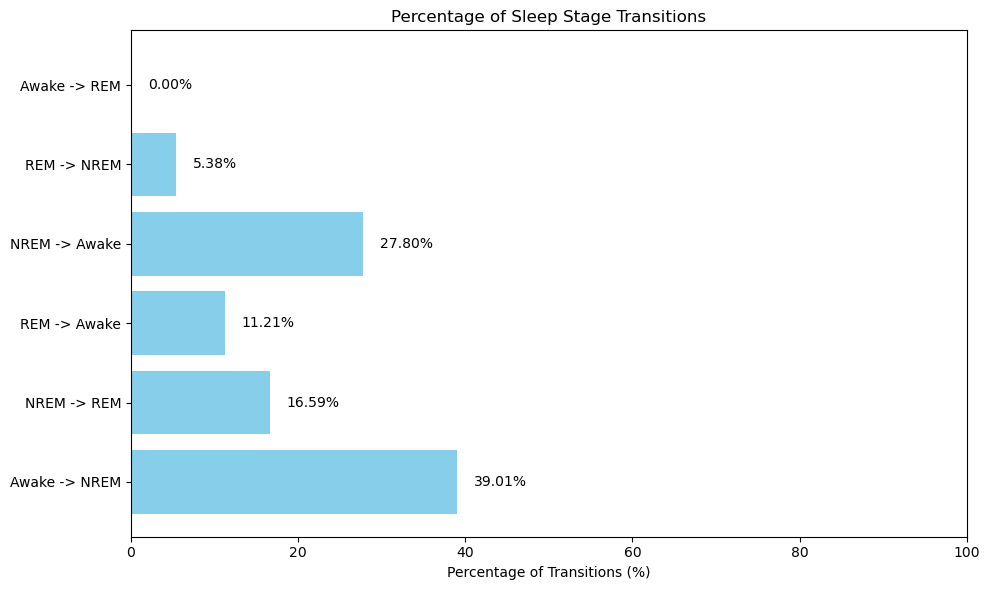

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sleep_transitions(file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Ensure that the sleepStage column exists
    if 'sleepStage' not in df.columns:
        raise ValueError("The CSV file must contain a 'sleepStage' column")
    
    # Initialize a dictionary to count the transitions
    transitions = {
        (1, 2): 0,  # Awake to NREM (1 -> 2)
        (2, 3): 0,  # NREM to REM (2 -> 3)
        (3, 1): 0,  # REM to Awake (3 -> 1)
        (2, 1): 0,  # NREM to Awake (2 -> 1)
        (3, 2): 0,  # REM to NREM (3 -> 2)
        (1, 3): 0   # Awake to REM (1 -> 3)
    }
    
    # Loop through the dataframe and count the transitions
    for i in range(len(df) - 1):
        current_stage = df.iloc[i]['sleepStage']
        next_stage = df.iloc[i + 1]['sleepStage']
        
        if (current_stage, next_stage) in transitions:
            transitions[(current_stage, next_stage)] += 1
    
    # Calculate the total number of transitions
    total_transitions = sum(transitions.values())
    if total_transitions == 0:
        print("No transitions detected in the data.")
        return
    
    # Calculate the percentage of each transition
    transition_percentages = {
        key: (count / total_transitions) * 100 
        for key, count in transitions.items()
    }
    
    # Prepare data for plotting
    transition_labels = ['Awake -> NREM', 'NREM -> REM', 'REM -> Awake', 
                         'NREM -> Awake', 'REM -> NREM', 'Awake -> REM']
    transition_data = [transition_percentages[(1, 2)], transition_percentages[(2, 3)], 
                       transition_percentages[(3, 1)], transition_percentages[(2, 1)], 
                       transition_percentages[(3, 2)], transition_percentages[(1, 3)]]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(transition_labels, transition_data, color='skyblue')
    plt.xlabel('Percentage of Transitions (%)')
    plt.title('Percentage of Sleep Stage Transitions')
    plt.xlim(0, 100)
    
    # Add percentage labels on the bars
    for i, v in enumerate(transition_data):
        plt.text(v + 2, i, f'{v:.2f}%', va='center', color='black', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Example usage
# plot_sleep_transitions('your_file.csv')

# Example usage
plot_sleep_transitions("/Volumes/harris/volkan/sleep_profile/downsample_auto_score/sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv")


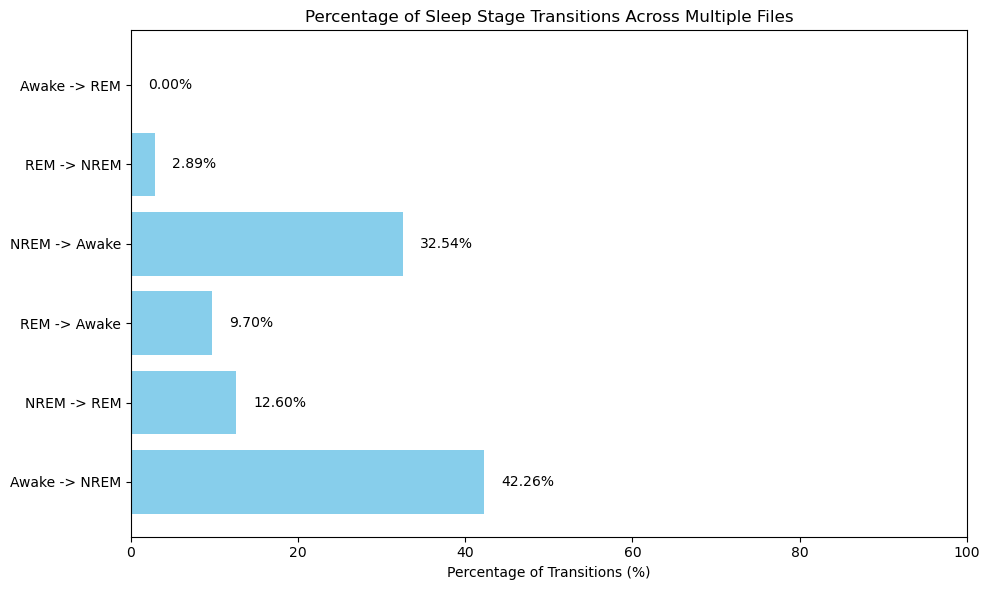

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sleep_transitions_multiple(files):
    # Initialize a dictionary to count the transitions across all files
    transitions = {
        (1, 2): 0,  # Awake to NREM (1 -> 2)
        (2, 3): 0,  # NREM to REM (2 -> 3)
        (3, 1): 0,  # REM to Awake (3 -> 1)
        (2, 1): 0,  # NREM to Awake (2 -> 1)
        (3, 2): 0,  # REM to NREM (3 -> 2)
        (1, 3): 0   # Awake to REM (1 -> 3)
    }
    
    # Loop over the files and process each one
    for file_path in files:
        # Load the current CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Ensure that the sleepStage column exists in the current file
        if 'sleepStage' not in df.columns:
            raise ValueError(f"The file {file_path} must contain a 'sleepStage' column")
        
        # Loop through the dataframe and count the transitions
        for i in range(len(df) - 1):
            current_stage = df.iloc[i]['sleepStage']
            next_stage = df.iloc[i + 1]['sleepStage']
            
            if (current_stage, next_stage) in transitions:
                transitions[(current_stage, next_stage)] += 1
    
    # Calculate the total number of transitions
    total_transitions = sum(transitions.values())
    if total_transitions == 0:
        print("No transitions detected across the provided files.")
        return
    
    # Calculate the percentage of each transition
    transition_percentages = {
        key: (count / total_transitions) * 100 
        for key, count in transitions.items()
    }
    
    # Prepare data for plotting
    transition_labels = ['Awake -> NREM', 'NREM -> REM', 'REM -> Awake', 
                         'NREM -> Awake', 'REM -> NREM', 'Awake -> REM']
    transition_data = [transition_percentages[(1, 2)], transition_percentages[(2, 3)], 
                       transition_percentages[(3, 1)], transition_percentages[(2, 1)], 
                       transition_percentages[(3, 2)], transition_percentages[(1, 3)]]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(transition_labels, transition_data, color='skyblue')
    plt.xlabel('Percentage of Transitions (%)')
    plt.title('Percentage of Sleep Stage Transitions Across Multiple Files')
    plt.xlim(0, 100)
    
    # Add percentage labels on the bars
    for i, v in enumerate(transition_data):
        plt.text(v + 2, i, f'{v:.2f}%', va='center', color='black', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Example usage:
files = ['/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/sub-007_ses-01_recording-01_time-0-70.5h_sr-1hz.csv', '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/sub-010_ses-01_recording-01_time-0-69h_sr-1hz.csv', 
         '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/sub-011_ses-01_recording-01_time-0-72h_sr-1hz.csv','/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/sub-015_ses-01_recording-01_time-0-49h_sr-1hz_stitched.csv',
         '/Volumes/harris/volkan/sleep_profile/downsample_auto_score/bout_duration/sub-016_ses-02_recording-01_time-0-91h_sr-1hz.csv']
plot_sleep_transitions_multiple(files)
